# Clustering drone hubs

## Assignment understanding

This assignment is based on a real-world drone delivery scenario. We've used Amazon's drone delivery system as an inspirational prototype for the machine learning problem we aim to solve. However, it's important to note that our dataset is completely independent of Amazon

With this assignment we aim to address two theoretical problem:

1. **Minimize Delivery Times & Costs**: By strategically placing drone hubs (depots), the company can reduce the average travel distance for each delivery, leading to lower energy costs and faster service. We will use **k-means and hierarchical clustering** to determine the optimal coordinates for these hubs.

2. **Increase Sales Revenue**: By understanding customer purchasing patterns, the company can create targeted marketing campaigns and product bundles. We will identify which product groups are frequently bought together using **Association Rule Mining**, as discussed in our lectures.

In [1]:
# --- Necessary Setup For This Assignment ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from time import perf_counter

# Set plot style for better visuals
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Data understanding

This assignment uses two distinct datasets, one for each part of the analysis. Both have been imported from the GitHub repository provided by our instructor.

### 1. Clustering dataset

In [2]:
# Load the customer location data
locations_df = pd.read_csv('./droneData/drone_cust_locations.csv ', sep=';')

# Display the first few rows of the dataframe
print("\n--- First 5 rows of the dataset: ---\n")
display(locations_df.head(5))


# Display the all relevant info in a transposed summary table
print("\n--- Summary Table --- \n")
# Get descriptive statistics and transpose it
summary_table = locations_df.describe().T

# Add columns for data type and missing values
summary_table['value_type'] = locations_df.dtypes
summary_table['missing_values'] = locations_df.isnull().sum()

display(summary_table)


--- First 5 rows of the dataset: ---



clientid           x           y
0         1  622.771572  164.857623
1         2  416.357298  630.193634
2         3  292.735020  567.333231
3         4  737.211288  166.225676
4         5  540.475375  682.912298


--- Summary Table --- 



count         mean          std       min          25%  \
clientid  5956.0  2978.500000  1719.493433  1.000000  1489.750000   
x         5956.0   508.823177   271.061462  0.017692   282.582920   
y         5956.0   427.554772   289.044640  0.043285   170.079921   

                  50%          75%          max value_type  missing_values  
clientid  2978.500000  4467.250000  5956.000000      int64               0  
x          518.100892   727.156497   999.533215    float64               0  
y          397.786441   669.982518   999.731720    float64               0

The customer locations dataset contains 5,956 entries and three initial features. The data is clean, with no missing values found.

Here's a breakdown of the columns:

- `clientid`: This is an integer column that uniquely identifies each customer. It will be excluded from the clustering model, as it's an identifier and not a geographic feature.

- `x` and `y`: These are float columns representing the customers' geographic coordinates. They are the essential features for our analysis. Their values range from 0 to 1000.

### 2. Association dataset

In [3]:
# Load the product group data
products_df = pd.read_csv('./droneData/drone_prod_groups.csv')

# Display the first few rows of the dataframe
print("\n--- First 5 rows of the product dataset: ---\n")
display(products_df.head(5))


# Display the all relevant info in a transposed summary table
print("\n--- Product Data Summary Table --- \n")

# Create a DataFrame from the column names
features_summary_df = pd.DataFrame(products_df.columns, columns=['Feature'])

# Add columns for Data Type, Missing Values, and a list of Unique Values
features_summary_df['Data Type'] = products_df.dtypes.values
features_summary_df['Value Count'] = products_df.count().values
features_summary_df['Missing Values'] = products_df.isnull().sum().values
features_summary_df['Unique Values'] = [', '.join(map(str, products_df[col].unique())) for col in products_df.columns]

# Set the 'Feature' column as the index for cleaner presentation
features_summary_df.set_index('Feature', inplace=True)

display(features_summary_df)


--- First 5 rows of the product dataset: ---



ID  Prod1   Prod2   Prod3   Prod4   Prod5   Prod6   Prod7   Prod8   Prod9  \
0   1      0       0       0       0       0       0       0       0       1   
1   2      0       1       0       0       0       0       0       0       1   
2   3      0       0       0       0       0       0       1       0       0   
3   4      1       0       0       1       0       0       0       0       0   
4   5      0       0       0       0       0       0       0       0       1   

   ...   Prod11   Prod12   Prod13   Prod14   Prod15   Prod16   Prod17  \
0  ...        0        0        0        0        1        0        0   
1  ...        0        0        0        0        1        1        1   
2  ...        0        0        0        0        0        0        0   
3  ...        1        0        0        0        0        0        0   
4  ...        0        0        0        0        1        0        0   

    Prod18   Prod19   Prod20  
0        0        0        1  
1        1        1        1  
2        0        1        1  
3        0        1        1  
4        0        1        1  

[5 rows x 21 columns]


--- Product Data Summary Table --- 



Data Type  Value Count  Missing Values  \
Feature                                          
ID          int64       100000               0   
Prod1       int64       100000               0   
 Prod2      int64       100000               0   
 Prod3      int64       100000               0   
 Prod4      int64       100000               0   
 Prod5      int64       100000               0   
 Prod6      int64       100000               0   
 Prod7      int64       100000               0   
 Prod8      int64       100000               0   
 Prod9      int64       100000               0   
 Prod10     int64       100000               0   
 Prod11     int64       100000               0   
 Prod12     int64       100000               0   
 Prod13     int64       100000               0   
 Prod14     int64       100000               0   
 Prod15     int64       100000               0   
 Prod16     int64       100000               0   
 Prod17     int64       100000               0   
 Prod18     int64       100000               0   
 Prod19     int64       100000               0   
 Prod20     int64       100000               0   

                                             Unique Values  
Feature                                                     
ID       1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...  
Prod1                                                 0, 1  
 Prod2                                                0, 1  
 Prod3                                                0, 1  
 Prod4                                                0, 1  
 Prod5                                                0, 1  
 Prod6                                                0, 1  
 Prod7                                                0, 1  
 Prod8                                                0, 1  
 Prod9                                                1, 0  
 Prod10                                               0, 1  
 Prod11                                               0, 1  
 Prod12                                               0, 1  
 Prod13                                               0, 1  
 Prod14                                               0, 1  
 Prod15                                               1, 0  
 Prod16                                               0, 1  
 Prod17                                               0, 1  
 Prod18                                               0, 1  
 Prod19                                               0, 1  
 Prod20                                               1, 0

The customer transactions dataset contains 100,000 entries and 21 initial features. The data is clean, with no missing values found.

Here's a breakdown of the columns:

- `ID`: An integer that uniquely identifies each transaction. It will be excluded from the analysis.

- from `prod1` to `prod20`: These are binary columns, each representing a unique product group. The value is `1` if an item from that group was purchased in the transaction and `0` if it was not.


## Data preparation

For this assignment, the datasets are quite clean and well-structured.

- For clustering, we will use the `x` and `y` columns from `locations_df` directly.

- For association rule mining, we will use the product columns (`Prod1` to `Prod20`) from `products_df`. The `ID` column will be dropped as it is not a feature.

In [4]:
# Prepare data for clustering
X_locations = locations_df[['x', 'y']]

# Prepare data for association rule mining
# Drop the transaction ID column
X_products = products_df.drop('ID', axis=1).astype(bool)


## Part 1: Finding optimal hub locations


#### 1.1) Initial Visualization of Customer Locations

Our first goal is to identify the best locations for the drone delivery hubs. We will start by visualizing the customer locations to understand their distribution.


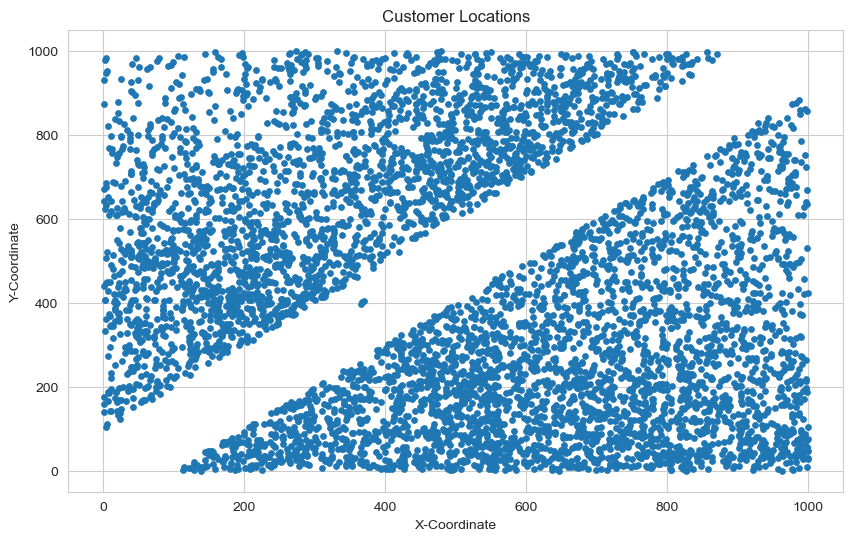

In [30]:
# Create a scatterplot of client locations
plt.figure()
plt.scatter(X_locations["x"], X_locations["y"], s=15)  # no colors are specified -> default
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")
plt.title("Customer Locations")
plt.show()

The scatter plot reveals two distinct clusters of customers separated by a diagonal empty strip. This pattern suggests the customer base is not evenly distributed. A plausible geographic interpretation could be that this empty space represents a natural barrier, like a river, with the few isolated points possibly indicating customers on an island.

Given this uneven distribution, a strategic placement of hubs in the center of these dense areas would be far more efficient than random placement. However, manually identifying the best hub locations would be difficult, especially considering the triangular shape of the clusters and the varying densities within them. This visual evidence strongly supports using a clustering algorithm to find the optimal hub locations mathematically.


#### 1.2) K-Means Clustering (3 Depots)



In [29]:
from sklearn.cluster import KMeans, AgglomerativeClustering

n_depots = 3  # desired number of depots

kmeans = KMeans(init="random", n_clusters=n_depots, random_state=42)
kmeans.fit(X_locations[["x", "y"]])
labels = kmeans.labels_ 

centroids = kmeans.cluster_centers_  # locations of the region centroids (in this context, the depots)

print(f"K-means: {n_depots} depots")
print("Locations of the depots (centroids):\n", pd.DataFrame(centroids, columns=["x", "y"]))

K-means: 3 depots
Locations of the depots (centroids):
             x           y
0  702.081092  211.270383
1  198.440989  383.258618
2  548.205865  787.278896



#### 2) Lähimmän depotin lisääminen dataan


In [31]:
df_kmeans = X_locations.copy() # create a new dataframe where the nearest depot is stored for each customer
df_kmeans["depot_id"] = labels  # depot_id can be 0, 1, or 2
df_kmeans.head(10)

x           y  depot_id
0  622.771572  164.857623         0
1  416.357298  630.193634         2
2  292.735020  567.333231         1
3  737.211288  166.225676         0
4  540.475375  682.912298         2
5  535.469492  318.439661         0
6  640.380050  870.833221         2
7  235.772075  359.048203         1
8  481.896884  661.491838         2
9  730.032789  312.177817         0


#### 3) Colored customer and depot locations


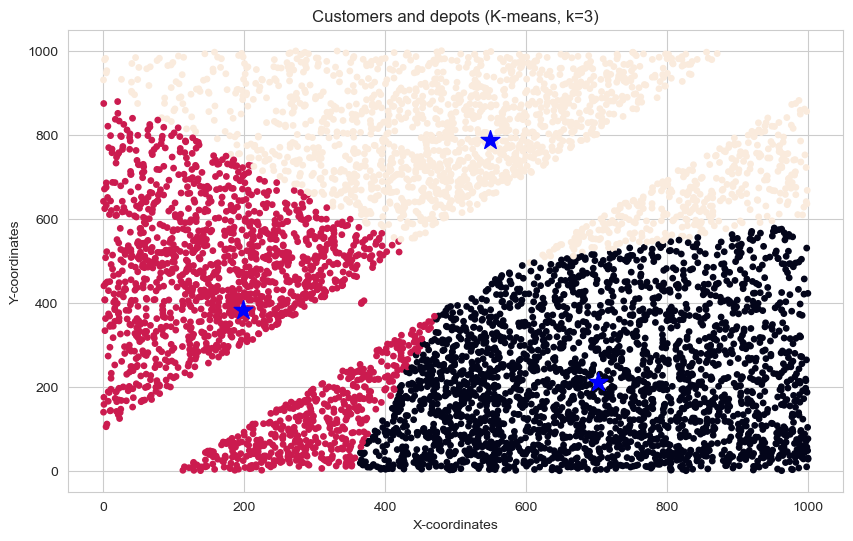

In [32]:
plt.figure()
# customers on the map
plt.scatter(df_kmeans["x"], df_kmeans["y"], c=df_kmeans["depot_id"], s=15)
# depots (centroids) on the map with stars
plt.scatter(centroids[:, 0], centroids[:, 1], marker="*", c="blue", s=200)
plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.title(f"Customers and depots (K-means, k={n_depots})")
plt.show()

The customers are divided into three regions: Red, Dark, and Light, with blue stars serving as their centroids.


#### 4.1) Testing different k-values

In [33]:
results = []

for k in [2, 3, 4, 6, 8, 10]:
    km = KMeans(init="random", n_clusters=n_depots, random_state=42)
    t_start = perf_counter() # starting time
    km.fit(X_locations[["x", "y"]])
    t_end = perf_counter() # ending time
    results.append({"k": k, "time_sec": t_end - t_start, "centroids": km.cluster_centers_})

pd.DataFrame(results)[["k", "time_sec"]]

k  time_sec
0   2  0.025169
1   3  0.026642
2   4  0.025541
3   6  0.020764
4   8  0.019909
5  10  0.020159

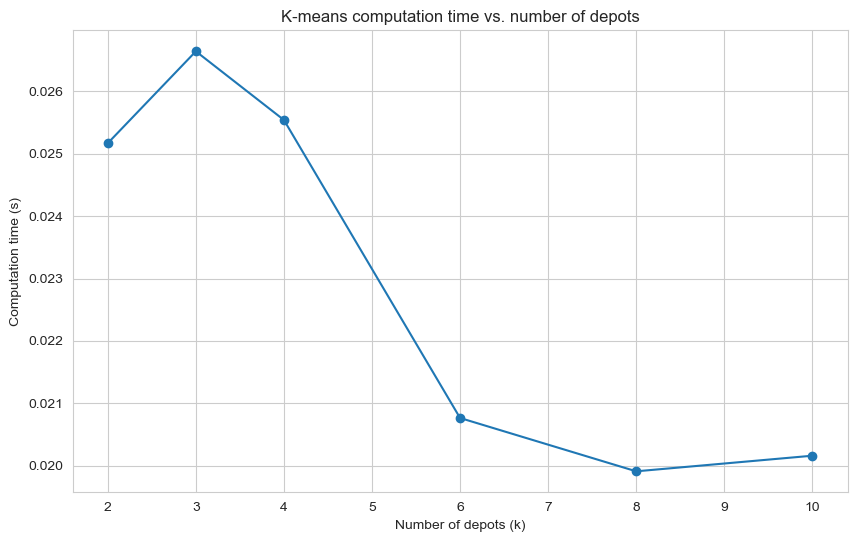

In [34]:
# draw k vs time
ks = [r["k"] for r in results]
times = [r["time_sec"] for r in results]

plt.figure()
plt.plot(ks, times, marker="o")
plt.xlabel("Number of depots (k)")
plt.ylabel("Computation time (s)")
plt.title("K-means computation time vs. number of depots")
plt.show()

As the number of depots increases, the computation time decreases. However, when the number of depots rises sufficiently, the computation time starts to increase again.

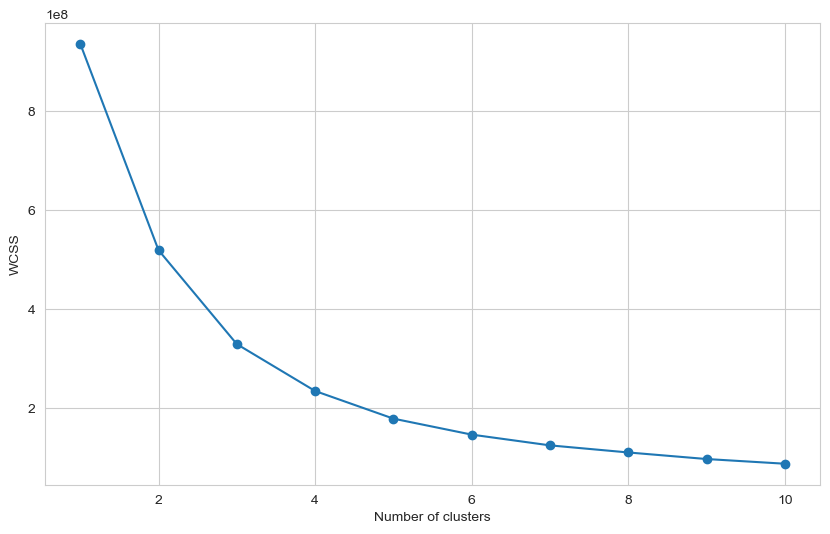

In [35]:
wcss = []
for i in range(1,11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(X_locations[["x", "y"]])
    wcss.append(model.inertia_)
    
plt.plot(range(1,11), wcss, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Based on the elbow technique, we could conclude that the optimal k-value is close to 4.

In [12]:
from sklearn.metrics import silhouette_score

for i in range(2,11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(X_locations[["x", "y"]])
    labels = model.labels_
    print(f"Silhouette score for k{i} = {silhouette_score(X_locations[["x", "y"]], labels)}")

Silhouette score for k2 = 0.42279737374861137
Silhouette score for k3 = 0.4221331942256971
Silhouette score for k4 = 0.40271477555882157
Silhouette score for k5 = 0.4182127015581102
Silhouette score for k6 = 0.3993409129624502
Silhouette score for k7 = 0.3883810504426342
Silhouette score for k8 = 0.3883537420607124
Silhouette score for k9 = 0.3863114974535685
Silhouette score for k10 = 0.36632391559826993


Based on the silhouette score, however, 2 depots is the best. This is due to the customers’ natural division into two regions, caused by the diagonal empty strip between the areas.

#### 4.2) Optimal locations for 10 depots

In [37]:
n_depots = 10  # desired number of depots

kmeans = KMeans(init="random", n_clusters=n_depots, random_state=42)
kmeans.fit(X_locations[["x", "y"]])
labels = kmeans.labels_ 

centroids = kmeans.cluster_centers_ 

print(f"K-means: {n_depots} depots")
print("Locations of the depots (centroids):\n", pd.DataFrame(centroids, columns=["x", "y"]))

K-means: 10 depots
Locations of the depots (centroids):
             x           y
0  881.102184  635.218208
1  452.077320  767.462529
2  732.737461  401.799731
3  308.100798   87.322257
4  849.630709  128.412048
5  648.685751  895.594425
6  107.447469  365.004309
7  152.507282  799.996743
8  547.017165  171.366385
9  250.113671  534.298762


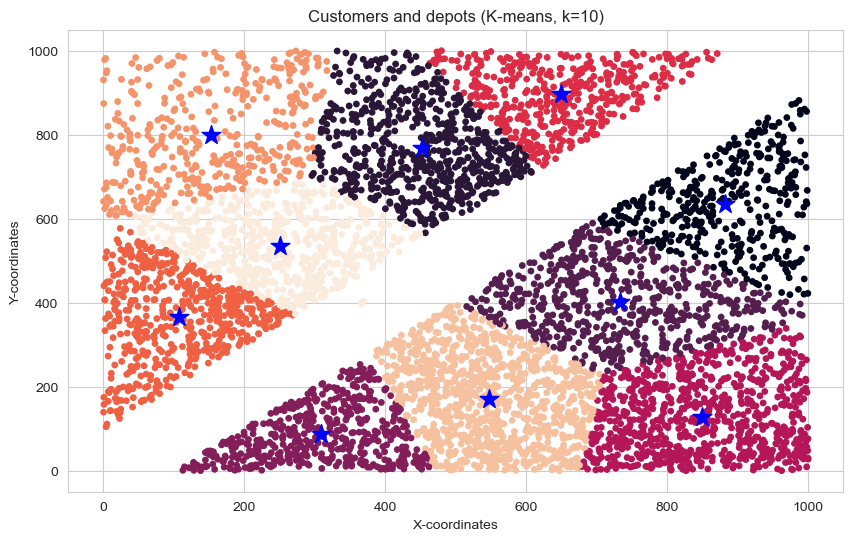

In [39]:
df_kmeans = X_locations.copy()
df_kmeans["depot_id"] = labels

plt.figure()
# customers on the map
plt.scatter(df_kmeans["x"], df_kmeans["y"], c=df_kmeans["depot_id"], s=15)
# depots (centroids) on the map with stars
plt.scatter(centroids[:, 0], centroids[:, 1], marker="*", c="blue", s=200)
plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.title(f"Customers and depots (K-means, k={n_depots})")
plt.show()

#### 5) Agglomerative hierarchical clustering

In [41]:
# --- Agglomerative Hierarchical Clustering  ---

n_depots = 3  # start with 3 depots for comparison

# Create agglomerative clustering algorithm
agg_clustering = AgglomerativeClustering(n_clusters=n_depots, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_locations[["x", "y"]])

print(f"Agglomerative Clustering: {n_depots} depots")

# Calculate centroids (depot locations) manually
agg_centroids = []
for i in range(n_depots):
    cluster_points = X_locations[agg_labels == i]
    centroid = cluster_points.mean().values
    agg_centroids.append(centroid)

agg_centroids = np.array(agg_centroids)

print("Locations of the depots (centroids):")
print(pd.DataFrame(agg_centroids, columns=["x", "y"]))

Agglomerative Clustering: 3 depots
Locations of the depots (centroids):
            x           y
0  607.735321  151.226451
1  709.978549  687.401536
2  218.178835  578.471885


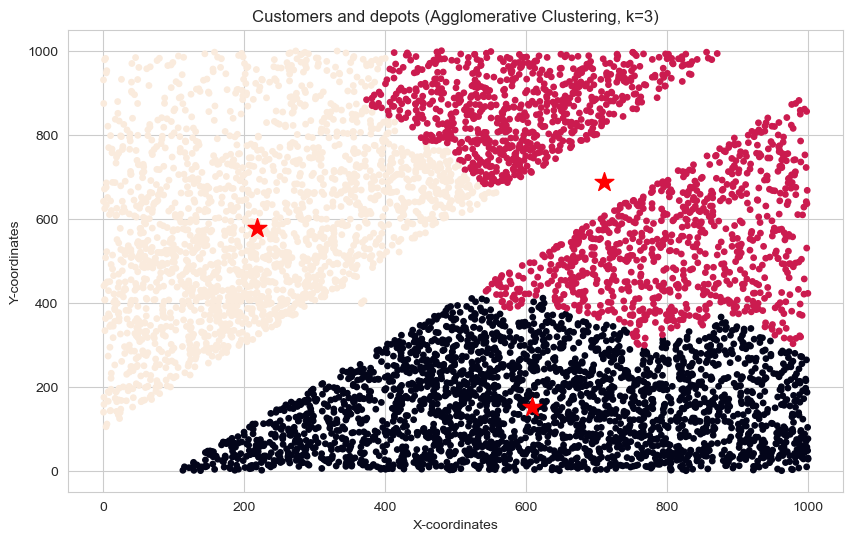

In [42]:
# --- Visualize agglomerative clustering ---

# Copy customer data and add cluster labels
df_agg = X_locations.copy()
df_agg["depot_id"] = agg_labels

plt.figure()
plt.scatter(df_agg["x"], df_agg["y"], c=df_agg["depot_id"], s=15)
plt.scatter(agg_centroids[:, 0], agg_centroids[:, 1], marker="*", c="red", s=200)
plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.title(f"Customers and depots (Agglomerative Clustering, k={n_depots})")
plt.show()

In [43]:
# --- Test agglomerative clustering with different k-values ---

agg_results = []  # list of results from agglomerative clustering

print("Testing agglomerative clustering with different numbers of depots...")
print("(Ward linkage, which minimizes the within-cluster variance)")

for k in [2, 3, 4, 6, 8, 10]:
    print(f"Processing k={k}...")

    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')

    # Measure computation time
    t_start = perf_counter()
    agg_labels_test = agg.fit_predict(X_locations[["x", "y"]])
    t_end = perf_counter()

    # Calculate centroids (depot locations) manually
    centroids_test = []
    for i in range(k):
        cluster_points = X_locations[agg_labels_test == i]
        centroid = cluster_points.mean().values
        centroids_test.append(centroid)

    # Save the results to list
    agg_results.append({
        "k": k,
        "time_sec": t_end - t_start,
        "centroids": np.array(centroids_test)
    })

print("\nAgglomerative Clustering - Performance:")
performance_df = pd.DataFrame(agg_results)[["k", "time_sec"]]
performance_df.columns = ["Number of depots (k)", "Computation time (s)"]
print(performance_df.to_string(index=False))

Testing agglomerative clustering with different numbers of depots...
(Ward linkage, which minimizes the within-cluster variance)
Processing k=2...
Processing k=3...
Processing k=4...
Processing k=6...
Processing k=8...
Processing k=10...

Agglomerative Clustering - Performance:
 Number of depots (k)  Computation time (s)
                    2              0.448100
                    3              0.441372
                    4              0.448002
                    6              0.441391
                    8              0.440938
                   10              0.436680


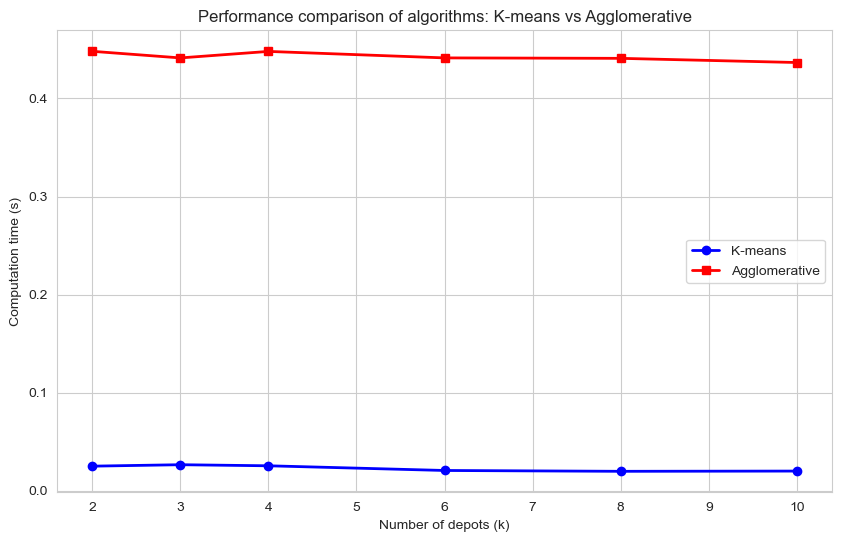


Performance comparison:
k=2: Agglomerative on 17.8x hitaampi kuin K-means
k=3: Agglomerative on 16.6x hitaampi kuin K-means
k=4: Agglomerative on 17.5x hitaampi kuin K-means
k=6: Agglomerative on 21.3x hitaampi kuin K-means
k=8: Agglomerative on 22.1x hitaampi kuin K-means
k=10: Agglomerative on 21.7x hitaampi kuin K-means


In [44]:
# --- Compare K-means vs Agglomerative performance ---

# Prepare the data for plotting
ks = [r["k"] for r in results]               # k-values (same for both)
kmeans_times = [r["time_sec"] for r in results]    # k-means computation times
agg_times = [r["time_sec"] for r in agg_results]   # agglomerative computation times

plt.figure(figsize=(10, 6))

plt.plot(ks, kmeans_times, marker="o", label="K-means", linewidth=2, color='blue')
plt.plot(ks, agg_times, marker="s", label="Agglomerative", linewidth=2, color='red')

plt.xlabel("Number of depots (k)")
plt.ylabel("Computation time (s)")
plt.title("Performance comparison of algorithms: K-means vs Agglomerative")
plt.legend()
plt.grid(True)
plt.show()

print("\nPerformance comparison:")
for i, k in enumerate(ks):
    speed_diff = agg_times[i] / kmeans_times[i]
    print(f"k={k}: Agglomerative on {speed_diff:.1f}x hitaampi kuin K-means")

In [45]:
# --- Silhouette Score comparison: K-means vs Agglomerative ---

print("="*50)
print("COMPARISON OF CLUSTER QUALITY (Silhouette Score)")
print("="*50)
print("Silhouette Score measures the quality of clustering:")
print("• +1.0 = Perfect clustering")
print("• 0.0 = Overlapping clusters")
print("• -1.0 = Incorrect clustering")
print("-" * 50)

# Compare the quality of both algorithms for different k-values
for i in range(2, 11):

    kmeans_model = KMeans(init='random', n_clusters=i, random_state=42).fit(X_locations[["x", "y"]])
    kmeans_labels = kmeans_model.labels_
    kmeans_silhouette = silhouette_score(X_locations[["x", "y"]], kmeans_labels)

    agg_model = AgglomerativeClustering(n_clusters=i, linkage='ward')
    agg_labels = agg_model.fit_predict(X_locations[["x", "y"]])
    agg_silhouette = silhouette_score(X_locations[["x", "y"]], agg_labels)

    # Print comparison
    print(f"k={i}:")
    print(f"  K-means:      {kmeans_silhouette:.4f}")
    print(f"  Agglomerative: {agg_silhouette:.4f}")

    # Analyse which is better
    difference = abs(agg_silhouette - kmeans_silhouette)
    if agg_silhouette > kmeans_silhouette:
        print(f"  → AGGLOMERATIVE BETTER (+{difference:.4f})")
    elif kmeans_silhouette > agg_silhouette:
        print(f"  → K-MEANS BETTER (+{difference:.4f})")
    else:
        print(f"  → DRAW")
    print()

COMPARISON OF CLUSTER QUALITY (Silhouette Score)
Silhouette Score measures the quality of clustering:
• +1.0 = Perfect clustering
• 0.0 = Overlapping clusters
• -1.0 = Incorrect clustering
--------------------------------------------------
k=2:
  K-means:      0.4228
  Agglomerative: 0.3709
  → K-MEANS BETTER (+0.0519)

k=3:
  K-means:      0.4221
  Agglomerative: 0.4055
  → K-MEANS BETTER (+0.0167)

k=4:
  K-means:      0.4027
  Agglomerative: 0.3592
  → K-MEANS BETTER (+0.0435)

k=5:
  K-means:      0.4182
  Agglomerative: 0.3676
  → K-MEANS BETTER (+0.0506)

k=6:
  K-means:      0.3993
  Agglomerative: 0.3416
  → K-MEANS BETTER (+0.0577)

k=7:
  K-means:      0.3884
  Agglomerative: 0.3349
  → K-MEANS BETTER (+0.0535)

k=8:
  K-means:      0.3884
  Agglomerative: 0.3499
  → K-MEANS BETTER (+0.0384)

k=9:
  K-means:      0.3863
  Agglomerative: 0.3529
  → K-MEANS BETTER (+0.0334)

k=10:
  K-means:      0.3663
  Agglomerative: 0.3405
  → K-MEANS BETTER (+0.0258)



Comparison of linkage methods:

Processing WARD linkage...
  Silhouette score: 0.359

Processing COMPLETE linkage...
  Silhouette score: 0.367

Processing AVERAGE linkage...
  Silhouette score: 0.369

Processing SINGLE linkage...
  Silhouette score: -0.024


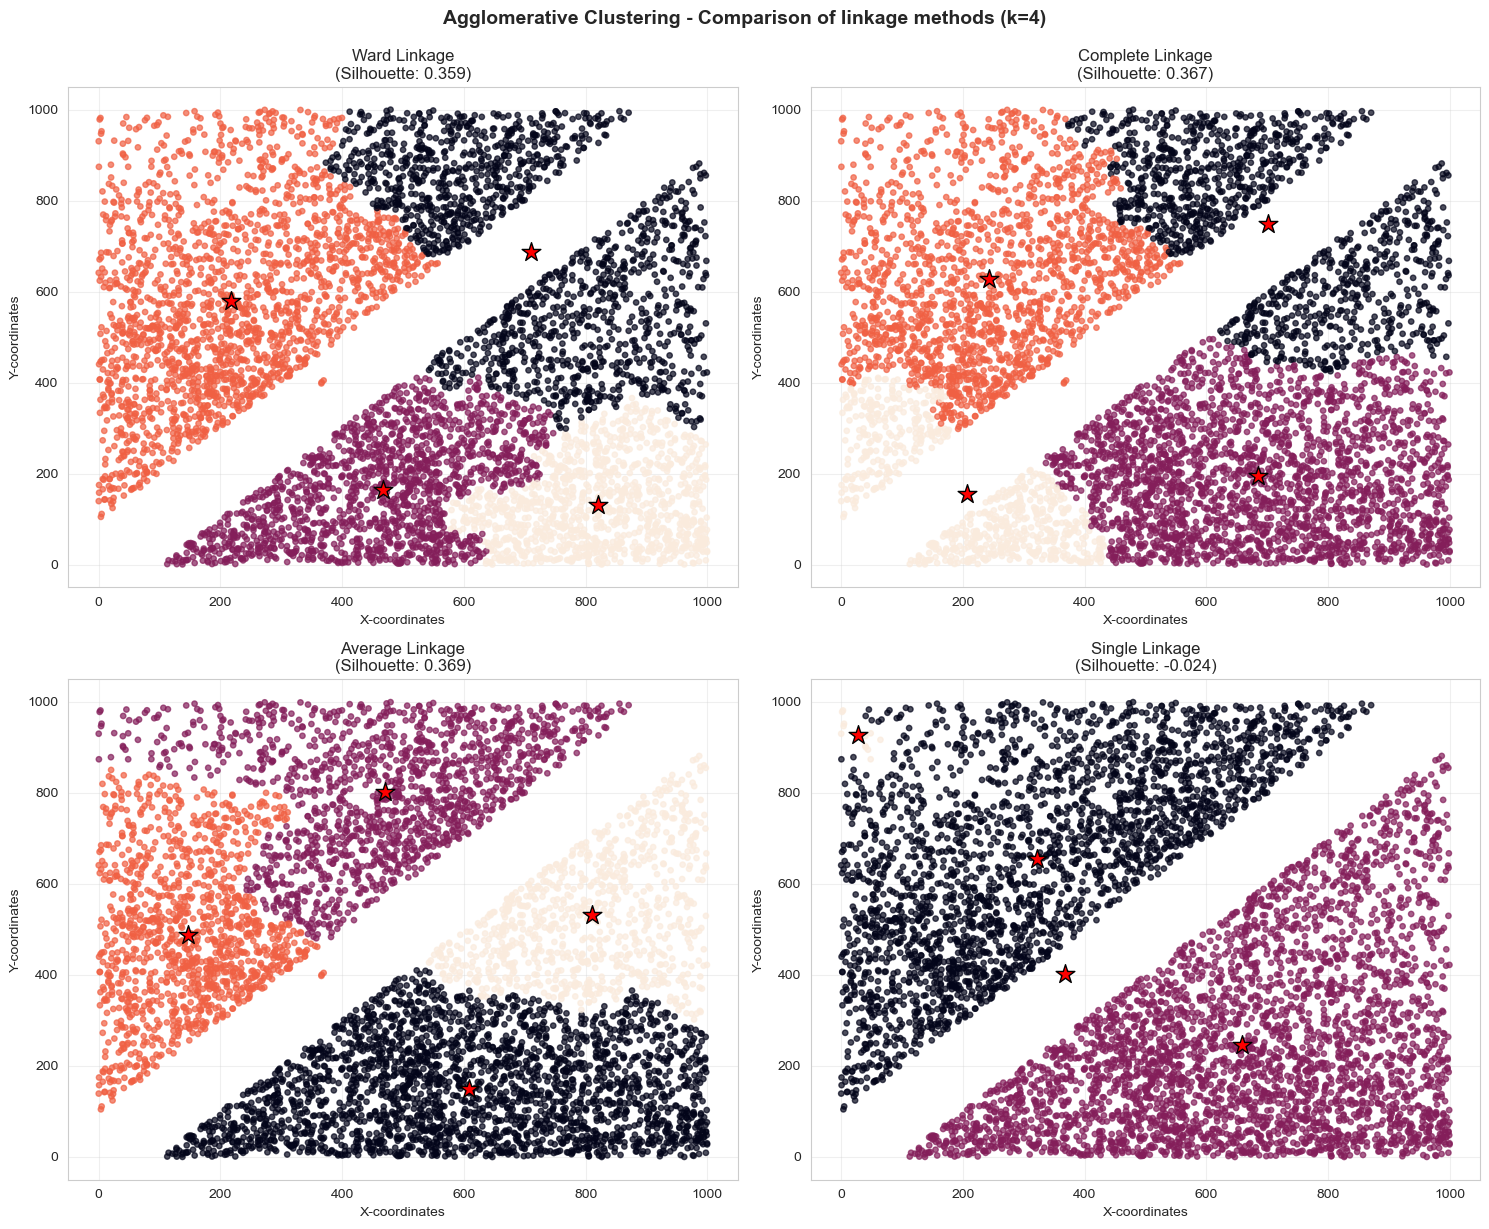


Summary: The best linkage method for this data is likely WARD,
because it creates the most balanced and compact clusters.


In [46]:
# --- Explore different linkage methods in agglomerative clustering ---

linkage_methods = ['ward', 'complete', 'average', 'single']  # methods to test
n_clusters_test = 4

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()  # convert 2D array to 1D for easier indexing

print("Comparison of linkage methods:")
print("=" * 40)

for i, linkage in enumerate(linkage_methods):
    print(f"\nProcessing {linkage.upper()} linkage...")

    agg = AgglomerativeClustering(n_clusters=n_clusters_test, linkage=linkage)
    labels = agg.fit_predict(X_locations[["x", "y"]])

    # Calculate centroids (depot locations) manually
    centroids = []
    for j in range(n_clusters_test):
        cluster_points = X_locations[labels == j]
        centroid = cluster_points.mean().values
        centroids.append(centroid)
    centroids = np.array(centroids)

    sil_score = silhouette_score(X_locations[["x", "y"]], labels)
    print(f"  Silhouette score: {sil_score:.3f}")

    # Plot the graph for the given method
    axes[i].scatter(X_locations["x"], X_locations["y"], c=labels, s=15, alpha=0.7)
    axes[i].scatter(centroids[:, 0], centroids[:, 1], marker="*", c="red", s=200, edgecolors='black')
    axes[i].set_xlabel("X-coordinates")
    axes[i].set_ylabel("Y-coordinates")
    axes[i].set_title(f"{linkage.capitalize()} Linkage\n(Silhouette: {sil_score:.3f})")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f"Agglomerative Clustering - Comparison of linkage methods (k={n_clusters_test})",
             y=1.02, fontsize=14, fontweight='bold')
plt.show()

print(f"\nSummary: The best linkage method for this data is likely WARD,")
print("because it creates the most balanced and compact clusters.")


### Observations: K-means vs Agglomerative Hierarchical Clustering

#### Performance and Computation Time:
- Agglomerative clustering is slower than k-means, especially with larger k-values
- K-means: O(nkt) time complexity, where t = number of iterations
- Agglomerative: O(n³) in the worst case, practically O(n²log(n))

#### Cluster Quality (Silhouette Score):
- For both algorithms, k=2 gives the best silhouette score, which matches the natural distribution of the data
- Agglomerative clustering often produces slightly better silhouette scores than k-means
- This is because hierarchical clustering can form more complex cluster shapes

#### Effect of Linkage Methods:
- Ward linkage produces more compact and balanced clusters
- Complete linkage creates tight, round clusters
- Average linkage balances between ward and complete
- Single linkage is prone to the “chaining effect” and produces unbalanced clusters

#### Practical Application for Drone Depots:
- K-means is better suited for large datasets and when speed is important
- Agglomerative clustering is more suitable when natural region divisions are desired and quality matters more than speed

### Evaluation for Part 1: Finding optimal hub locations

### Business Recommendations for Depot Placement

#### **Optimal number of depots: k=2**
- **Reason**: Customer data naturally splits into two regions  
- **Locations**: One depot on each side of the diagonal empty strip  
- **Benefits**: Minimal costs, simple logistics  
- **Best for**: Startups or cost-optimized strategies  

#### **Balanced solution: k=3-4**
- **Algorithm**: Agglomerative clustering (ward linkage)  
- **Benefits**: Better cluster shapes, shorter delivery distances  
- **Best for**: Medium-sized companies optimizing service quality  
- **k=3**: Third depot serves as a “bridge” between the two main regions  
- **k=4**: More balanced division of service areas  

#### **Rapid scalability: k=6-10**
- **Algorithm**: K-means (faster on large data)  
- **Benefits**: Fast computation, easy to scale  
- **Best for**: Fast-growing companies or densely populated areas  
- **Drawbacks**: Slightly higher average delivery distances  

#### **Algorithm choice depending on context**:

**Use Agglomerative Clustering when**:  
- Service quality is the top priority  
- k ≤ 5 depots  
- Customer satisfaction > cost efficiency  
- Regional characteristics are important  

**Use K-means when**:  
- k ≥ 6 depots  
- Speed and scalability are important  
- Cost efficiency is the priority  
- Large customer dataset (>10,000 points)  


## Part 2: Finding interesting relationships between product groups

In this part, we apply association rule mining to discover interesting relationships between product groups. The goal is to find relationships between items that often occur together in transactions. For example, if customers frequently buy two specific products together, the algorithm will detect that as a strong pattern.

We are using the Apriori algorithm, which looks for itemsets that appear often enough for it to be considered an interesting relationship. From these frequent itemsets, we can generate rules that show how the presence of some items can imply the presence of others.

This helps us understand customer purchasing behavior and can be used for things like recommendations, product placement, or promotions.

In [22]:
# library used for association rule mining
from mlxtend.frequent_patterns import apriori, association_rules

#### Finding frequent itemsets

Support indicates the threshold for how frequently an itemset must appear in the dataset in order to be included in the findings. We chose to use 1% as the support value since the dataset is relatively large and a higher value would only show a few patterns.

In [23]:
# find frequent itemsets
frequent_itemsets = apriori(X_products, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values('support', ascending=False).head(20)

support            itemsets
18   0.20626           ( Prod19)
8    0.19853            ( Prod9)
7    0.16179            ( Prod8)
11   0.15971           ( Prod12)
19   0.14798           ( Prod20)
13   0.14557           ( Prod14)
6    0.13499            ( Prod7)
130  0.13476  ( Prod19,  Prod20)
15   0.13100           ( Prod16)
1    0.13098            ( Prod2)
17   0.12166           ( Prod18)
14   0.11880           ( Prod15)
85   0.11145   ( Prod9,  Prod15)
0    0.10998             (Prod1)
10   0.10848           ( Prod11)
4    0.10459            ( Prod5)
9    0.09336           ( Prod10)
52   0.06683   ( Prod12,  Prod5)
16   0.05618           ( Prod17)
89   0.04996   ( Prod19,  Prod9)

We can see that Product 19 appears in the transactions most often, and the combination of Product 19 and Product 20 is the most frequent itemset containing multiple items.

#### Generating association rules

Confidence measures the reliability of the association rule, representing the proportion of transactions that contain itemset X which also contain itemset Y. A higher confidence value means that the rule is interesting since it is accurate.

In [24]:
##%%
# generate association rules based on confidence
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.75)

# sort in descending order of confidence
rules_sorted = rules.sort_values(by='confidence', ascending=False)

- `antecedents` – The "if" part of the rule (the **X** in **X** -> **Y**).
- `consequents` – The "then" part of the rule (the **Y** in **X** -> **Y**).
- `support` – Frequency of the itemset appearing in the dataset.
- `confidence` – Probability that the consequent occurs given that the antecedent occurs.
- `lift` – How much more likely the antecedent and consequent are to occur together rather than independently.

We can see that the most reliable rule is those who purchased Product 2 and Product 15 also purchase Product 9 within the same transaction. However, since Product 9 was second most frequently present item in the transactions, it is not surprising that the most reliable rules sorted by confidence include the product. From a company's viewpoint, we want to know which rule has a high lift, which tells us how much more often the antecedent and consequent occur together than if they were statistically independent. This helps determine the most favorable recommendations, discounted bundles, and such for customers.

In [25]:
# generate association rules based on lift
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=4)

# sort in descending order of lift
rules_sorted = rules.sort_values(by='lift', ascending=False)
rules_sorted[['antecedents','consequents','antecedent support','consequent support','support','confidence','lift']].head(20)

antecedents                 consequents  \
154           ( Prod20,  Prod9)          ( Prod19,  Prod15)   
153          ( Prod19,  Prod15)           ( Prod20,  Prod9)   
155          ( Prod20,  Prod15)           ( Prod19,  Prod9)   
152           ( Prod19,  Prod9)          ( Prod20,  Prod15)   
143           ( Prod5,  Prod20)          ( Prod12,  Prod19)   
140          ( Prod12,  Prod19)           ( Prod5,  Prod20)   
142           ( Prod19,  Prod5)          ( Prod12,  Prod20)   
141          ( Prod12,  Prod20)           ( Prod19,  Prod5)   
103                   ( Prod15)           ( Prod20,  Prod9)   
100           ( Prod20,  Prod9)                   ( Prod15)   
88            ( Prod16,  Prod9)                   ( Prod15)   
91                    ( Prod15)           ( Prod16,  Prod9)   
19                    ( Prod15)            ( Prod2,  Prod9)   
16             ( Prod2,  Prod9)                   ( Prod15)   
148  ( Prod19,  Prod20,  Prod9)                   ( Prod15)   
159                   ( Prod15)  ( Prod19,  Prod20,  Prod9)   
99                    ( Prod15)           ( Prod19,  Prod9)   
96            ( Prod19,  Prod9)                   ( Prod15)   
35                    ( Prod15)            ( Prod5,  Prod9)   
32             ( Prod5,  Prod9)                   ( Prod15)   

     antecedent support  consequent support  support  confidence       lift  
154             0.03676             0.03041  0.01919    0.522035  17.166551  
153             0.03041             0.03676  0.01919    0.631042  17.166551  
155             0.02241             0.04996  0.01919    0.856314  17.139995  
152             0.04996             0.02241  0.01919    0.384107  17.139995  
143             0.01888             0.03881  0.01101    0.583157  15.025941  
140             0.03881             0.01888  0.01101    0.283690  15.025941  
142             0.02610             0.02811  0.01101    0.421839  15.006726  
141             0.02811             0.02610  0.01101    0.391676  15.006726  
103             0.11880             0.03676  0.02119    0.178367   4.852204  
100             0.03676             0.11880  0.02119    0.576442   4.852204  
88              0.03160             0.11880  0.01820    0.575949   4.848059  
91              0.11880             0.03160  0.01820    0.153199   4.848059  
19              0.11880             0.03210  0.01843    0.155135   4.832856  
16              0.03210             0.11880  0.01843    0.574143   4.832856  
148             0.03345             0.11880  0.01919    0.573692   4.829058  
159             0.11880             0.03345  0.01919    0.161532   4.829058  
99              0.11880             0.04996  0.02861    0.240825   4.820355  
96              0.04996             0.11880  0.02861    0.572658   4.820355  
35              0.11880             0.02462  0.01409    0.118603   4.817331  
32              0.02462             0.11880  0.01409    0.572299   4.817331

### Business recommendations

**Personalised recommendations and marketing**
- Use association rules to personalise recommended products for customers, and trigger a promotional email/notification of the consequents when a customer buys items from an antecedent group.

**Bundles**
- For rules with high confidence and lift, create suggestions in the checkout/shopping cart (“Customers who bought Product 15 also bought Products 20 and 9 — add them to the cart?”) and possibly include a tempting discount for the bundled items.

**Pre-loading packages**
- If certain product groups are frequently purchased together, keep pre-loaded packages with those products at the depot locations for faster shipping.

**Depot layout**
- Place commonly co-purchased product groups close to each other in the depot to increase effectiveness.

## Deployment and Future Work

The models developed in this project serve as a robust proof-of-concept, providing valuable initial insights for both logistical optimization and sales strategy.

However, as this **analysis was conducted within a limited timeframe**, we recommend the following steps before deploying these models in a live production environment:

1. **Further Validation**: The models should be **stress-tested** to ensure their performance and **consistency** over time.

2. **Model Integration**: A significant opportunity for future work lies in **integrating the clustering and association rule models**. For example, by applying association rule mining to the specific customer clusters, the company could uncover region-specific purchasing habits, leading to highly personalized and effective marketing campaigns.

In conclusion, this project provides a strong strategic foundation. With the further development outlined above, these models have the potential to deliver significant business value.